In [2]:
! pwd

/home/bsherwin51/Renaissance/RP


In [3]:
import h5py as h

In [4]:
ds = h.File('catalog.h5')
print(ds)

<HDF5 file "catalog.h5" (mode r)>


In [92]:
print(ds.keys()) # only 168 halos now

<KeysViewHDF5 ['Halo00000000', 'Halo00000001', 'Halo00000002', 'Halo00000003', 'Halo00000004', 'Halo00000005', 'Halo00000006', 'Halo00000007', 'Halo00000008', 'Halo00000009', 'Halo00000010', 'Halo00000011', 'Halo00000012', 'Halo00000013', 'Halo00000014', 'Halo00000015', 'Halo00000016', 'Halo00000017', 'Halo00000018', 'Halo00000019', 'Halo00000020', 'Halo00000021', 'Halo00000022', 'Halo00000023', 'Halo00000024', 'Halo00000025', 'Halo00000026', 'Halo00000027', 'Halo00000028', 'Halo00000029', 'Halo00000030', 'Halo00000031', 'Halo00000032', 'Halo00000033', 'Halo00000034', 'Halo00000035', 'Halo00000036', 'Halo00000037', 'Halo00000038', 'Halo00000039', 'Halo00000040', 'Halo00000041', 'Halo00000042', 'Halo00000043', 'Halo00000044', 'Halo00000045', 'Halo00000046', 'Halo00000047', 'Halo00000048', 'Halo00000049', 'Halo00000050', 'Halo00000051', 'Halo00000052', 'Halo00000053', 'Halo00000054', 'Halo00000055', 'Halo00000056', 'Halo00000057', 'Halo00000058', 'Halo00000059', 'Halo00000060', 'Halo0000

In [4]:
for key in ds.keys():
    print(ds[key].keys())
    break

<KeysViewHDF5 ['M_HI', 'M_HII', 'Mstar', 'Mstar_pop2', 'Mstar_pop2_young', 'Mstar_pop3', 'Nesc', 'Ntot', 'NumberOfPop2Stars', 'NumberOfPop3Stars', 'SFR', 'center', 'fesc', 'fgas', 'fstar', 'mass', 'redshift', 'rvir']>


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
all_groups = {}
fescs = []
groups = []
fgases = []
masses = []
SFRs = [] 
Mstars = []
redshifts = []
for halo in ds.keys(): # loops through halos
    fesc_list = list(ds[halo]['fesc'])
    fgas_list = list(ds[halo]['fgas'])
    mass_list = list(ds[halo]['mass'])
    SFR_list = list(ds[halo]['SFR'])
    Mstar_list = list(ds[halo]['Mstar'])
    redshift_list = list(ds[halo]['redshift'])    
    for index, fesc in enumerate(fesc_list):# loops thru timestep
        if fesc <= 0.01:
            group = 0
        elif 0.01 < fesc <= 0.10:
            group = 1
        elif 0.10 < fesc <= 0.25:
            group = 2
        else:
            group = 3
        # used enumerate to find index and only use "good" values
        if fesc >= 1e-5:
            fescs.append(fesc)
            groups.append(group)
            fgases.append(ds[halo]['fgas'][index])
            masses.append(ds[halo]['mass'][index])
            SFRs.append(ds[halo]['SFR'][index])
            Mstars.append(ds[halo]['Mstar'][index])
            redshifts.append(ds[halo]['redshift'][index])
    all_groups[halo] = groups

# Sanity check: All parameter arrays should be same size
print(len(fescs), len(fgases), len(masses), len(SFRs), len(Mstars), len(redshifts)) # length is 3122 for all

# Sanity check 2: Length of all_groups should be same as number of halos
print(len(ds.keys()) == len(all_groups)) # length is 168




2139 2139 2139 2139 2139 2139
True


In [5]:
print(np.unique(redshifts))

[15.         15.10046691 15.19957881 15.2999185  15.39881929 15.49892757
 15.6002656  15.7000668  15.80107527 15.90045631 16.00102006 16.0998632
 16.1998624  16.30103806 16.40038281 16.50087504 16.59943682 16.69911504
 16.7999288  16.8986934  16.99856012 17.09954751 17.20167455 17.30161054
 17.39926403 17.5013876  17.9000189  18.00057002 18.50078003 19.
 19.500205   19.99958001 20.50075253 20.99736032 21.50225023 21.99908004
 22.50176263 22.99808015 23.4977952  24.        ]


In [15]:
file = open('redshifts.dat')
file_names = []
file_redshifts = []
for line in file:
    data = line.split()
    file_names.append(data[0])
    file_redshifts.append(float(data[2]))
file_names = np.array(file_names)
file_redshifts = np.array(file_redshifts)

all_filename = {}
for halo in list(ds.keys())[0:4]:
    all_filename[halo] = []
    for z in ds[halo]['redshift']:
        idx = np.argmin(abs(file_redshifts - z))
        all_filename[halo].append(file_names[idx][2:6])
print(all_filename)        
''' 
pace_redshifts_RP = np.loadtxt('redshifts.dat', dtype = str, delimiter = ' ')
pace_redshifts = {}
eps = 1e-2

for i in range(len(pace_redshifts_RP)):
    pace_redshifts[pace_redshifts_RP[i][0][40:46]] = float(pace_redshifts_RP[i][4])

for value in pace_redshifts.values():
    for redshift in np.unique(redshifts):
        if np.abs(value - redshift) < eps:
            print(f'Match: {list(pace_redshifts.keys())[list(pace_redshifts.values()).index(value)]}, my value {redshift}, pace value {value}')
'''

{'Halo00000000': ['0041', '0040', '0039', '0038', '0037', '0036', '0035', '0034', '0033', '0032', '0031', '0030', '0029', '0028', '0027', '0026', '0025', '0024', '0023', '0022', '0021', '0020', '0019', '0018', '0017', '0016', '0015', '0014', '0013', '0012', '0011', '0010', '0009', '0008', '0007', '0006'], 'Halo00000001': ['0041', '0040', '0039', '0038', '0037', '0036', '0035', '0034', '0033', '0032', '0031', '0030', '0029', '0028', '0027', '0026', '0025', '0024', '0023', '0022', '0021', '0020', '0019', '0018', '0017', '0016', '0015', '0014', '0013'], 'Halo00000002': ['0041', '0040', '0039', '0038', '0037', '0036', '0035', '0034', '0033', '0032', '0031', '0030', '0029', '0028', '0027', '0026', '0025', '0024', '0023', '0022', '0021', '0020', '0019', '0018', '0017', '0016', '0015', '0014', '0013', '0012', '0011', '0010', '0009', '0008', '0007', '0006', '0005', '0004', '0003', '0002'], 'Halo00000003': ['0041', '0040', '0039', '0038', '0037', '0036', '0035', '0034', '0033', '0032', '0031', 

" \npace_redshifts_RP = np.loadtxt('redshifts.dat', dtype = str, delimiter = ' ')\npace_redshifts = {}\neps = 1e-2\n\nfor i in range(len(pace_redshifts_RP)):\n    pace_redshifts[pace_redshifts_RP[i][0][40:46]] = float(pace_redshifts_RP[i][4])\n\nfor value in pace_redshifts.values():\n    for redshift in np.unique(redshifts):\n        if np.abs(value - redshift) < eps:\n            print(f'Match: {list(pace_redshifts.keys())[list(pace_redshifts.values()).index(value)]}, my value {redshift}, pace value {value}')\n"

In [ ]:
for halo in halo_mmp:
    nnode = len(halo['redshift'])
    for f in fields:
        halo[f] = np.zeros(nnode)
    for inode in range(nnode):
        ip = find_nearest(redshifts, halo['redshift'][inode])
        
        # dr = separation, R = radius of target halo, r = radii of all catalog halos
        dr = np.sqrt(((halo['center'][inode] - catalog[ip]['center'])**2).sum(1))
        R = halo['rvir'][inode]
        r = catalog[ip]['rvir'] * (1 + redshifts[ip]) / trees.box_size.in_units('kpc').v
        
        # Calculate the sphere-sphere intersection. The maximum is the match.
        # http://mathworld.wolfram.com/Sphere-SphereIntersection.html
        vol = np.pi * (R+r-dr)**2 * (dr**2 + 2*dr*r - 3*r**2 + 2*dr*R + 6*r*R - 3*R**2) / (12*dr)
        vol[dr > r+R] = 0.0  # No intersection
        vol[dr < R-r] = (4*np.pi/3) * r[dr < R-r]**3  # Complete intersection
        
        match = vol.argmax()
        rvir = catalog[ip]['rvir'][match] * (1 + redshifts[ip]) / trees.box_size.in_units('kpc').v
        # Check whether separation is within the virial radius
        if dr[match] >= rvir:
            continue
        # Add halo properties to mmp history
        for f in fields:
            halo[f][inode] = catalog[ip][f][match]
    # Calculate SFR (last 20 Myr) [Msun/yr]
    halo['SFR'] = halo['Mstar_pop2_young'] / 20e6
    halo['fesc'] = np.maximum(halo['fesc'], 1e-6)

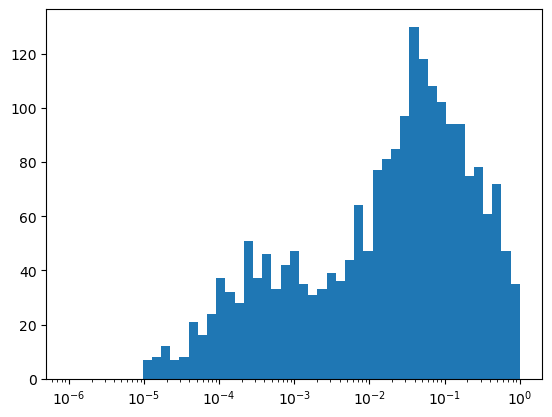

In [14]:
plt.hist(fescs, bins = np.logspace(-6, 0))
plt.xscale('log')

In [6]:
from yt.utilities.cosmology import Cosmology

co = Cosmology()

 
all_t_lookbacks = []
for halo in ds.keys():
    t_lookbacks_halo = []
    for z_idx in range(len(list(ds[halo]['redshift']))):
        t_lookback = co.t_from_z(0) - co.t_from_z(ds[halo]['redshift'][z_idx])
        t_lookbacks_halo.append(t_lookback)
    all_t_lookbacks.append(t_lookbacks_halo)

KeyboardInterrupt: 

In [9]:
arr2 = np.array(all_t_lookbacks)
np.save('t_lookback_RP', arr2)

/tmp/ipykernel_1496/3588806147.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr2 = np.array(all_t_lookbacks)


In [10]:
closest_halo_dist = [] # all halos concatenation of min_dist_at_z's

for i, halo1 in enumerate(ds.keys()):
    print(f"i = {i}")
    center_list = list(ds[halo1]['center'])
    n_redshifts_halo1 = len(list(ds[halo1]['redshift']))
    min_dist_at_z = [] # array of minimum distances at each redshift for halo N
    
    for z in range(n_redshifts_halo1):
        dist_to_halo1= [] # array of ALL distances at each redshift for halo N
        
        for j,halo2 in enumerate(ds.keys()):
            
            if i == j:
                continue
            
            center_list2 = list(ds[halo2]['center'])
            n_redshifts_halo2 = len(list(ds[halo2]['redshift']))
           
            
            if z >= n_redshifts_halo2:
                continue
                
            
            halo1_center = center_list[z]
            halo2_center = center_list2[z]
            
    
            dist_to_halo1.append(np.sqrt((halo1_center[0]-halo2_center[0])**2 + (halo1_center[1]-halo2_center[1])**2 + (halo1_center[2]-halo2_center[2])**2 ))
        

        if len(dist_to_halo1) == 0:
            continue
            
        min_dist_at_z.append(min(dist_to_halo1)) # PROBLEM WITH THIS
    
    closest_halo_dist.append(min_dist_at_z)


i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 13

In [11]:
arr = np.array(closest_halo_dist)
np.save('min_dist_RP', arr)

/tmp/ipykernel_1496/2297087013.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(closest_halo_dist)


## Architecture

In [7]:
import torch 
import torch.nn as nn
import numpy as np
import sys, os, time
import optuna # Optimizer

In [8]:
# 1 hidden layer code

# inp ---------> size of input data
# h1 ----------> size of first hidden layer
# out ---------> size of output data
# dr ----------> dropout rate
class model_1hl(nn.Module):
    
    def __init__(self, inp, h1, out, dr):
        super(model_1hl, self).__init__()

        self.fc1 = nn.Linear(inp, h1) # lin trans
        self.fc2 = nn.Linear(h1,  out)
        
        self.dropout   = nn.Dropout(p=dr) #normalizes by zeroing at random
        self.ReLU      = nn.ReLU() # RELU(x) = max(0,x)
        self.LeakyReLU = nn.LeakyReLU(0.2) # LeakyReLU = max(0,x) + neg_slope * min(0,x)
        
        # initialize the weights of the different layers
        for m in self.modules(): 
            if isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm1d): # if module is Batch normalization: y = gamma*(x -  E(x))/sqrt(Var(x) + eps) + b
                nn.init.constant_(m.weight, 1) 
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                 '''if module is 3D Convolution: over an input signal composed of several input planes. or ConvTranspose2d Applies a 3D transposed convolution operator over an input image composed of several input planes. The transposed convolution operator multiplies each input value element-wise by a learnable kernel, and sums over the outputs from all input feature planes. Or Lin Trans'''
                 nn.init.kaiming_normal_(m.weight) # normalization that makes extremely deep models (>30 layers) to converge
       
    # forward pass
    def forward(self, x):
        out = self.dropout(self.LeakyReLU(self.fc1(x))) # Apply leakyRELU on input and dropout normalize
        out = self.fc2(out) 
        # out = nn.Softmax(out)
        return out


In [9]:
# N hidden layer code, similar structure to above but generalized
def dynamic_model2(input_size, output_size, n_layers, hidden, dr):

    # define the tuple containing the different layers
    layers = []

    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = hidden[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Dropout(dr[i]))
        in_features = out_features

    # get the last layer
    layers.append(nn.Linear(out_features, output_size))

    # return the model
    return nn.Sequential(*layers)

#model = dynamic_model2(numFeatures, outSize, numHL, [h1, h2], [dr1, dr1])

## Data

In [10]:
from random import shuffle
import torch 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import sys, os, time, h5py
from pathlib import Path

In [11]:
def normalize_data(data, labels):
    ######################
    # normalize input
    ## the id's correspond to the id's of the feature array you made using vstack in read_data()
    data[:,0]  = (data[:,0] - np.mean(data[:,0]))/np.std(data[:,0]) # Z Scores
    data[:,1]  = (data[:,1] - np.mean(data[:,1]))/np.std(data[:,1])
    data[:,2]  = (data[:,2] - np.mean(data[:,2]))/np.std(data[:,2])
    data[:,3]  = (data[:,3] - np.mean(data[:,3]))/np.std(data[:,3])
    data[:,4]  = (data[:,4] - np.mean(data[:,4]))/np.std(data[:,4])

    ######################
    # normalize labels
    print ("labels", labels)

    # # array = np.log10(labels) # Since labels are large log them
    # print("labels array", array)
    # labels = array
    
    return data, labels

In [12]:
# read data and get training, validation or testing sets
# fin ---------> file with the data
# seed --------> random seed used to split among different datasets
# mode --------> 'train', 'valid', 'test' or 'all'
# normalize ---> whether to normalize the data or not
def read_data(fin, seed, mode, normalize): #fin for h5
    File = 'catalog.h5'
    f     = h5py.File(fin, 'r')
    masses = []
    fgases = []
    SFRs = []
    Mstars = []
    redshifts = []
    fescs = []
    groups = []
    min_dist = []
    t_lookback = []
    
    t_lookback_RP = np.array(np.load('t_lookback_RP.npy', allow_pickle = True))
    t_lookback_all = []
    for list_i in t_lookback_RP:
        for elem in list_i:
            t_lookback_all.append(elem)
        
    min_dist_RP = np.array(np.load('min_dist_RP.npy', allow_pickle = True))
    min_dist_all = []
    for listi in min_dist_RP:
        for elem in listi:
            min_dist_all.append(elem)
    
    for halo in f.keys():
        fesc_list = list(f[halo]['fesc']) 
        for index, fesc in enumerate(fesc_list):
            if fesc <= 0.01:
                group = 0
            elif 0.01 < fesc <= 0.10:
                group = 1
            elif 0.10 < fesc <= 0.25:
                group = 2
            else:
                group = 3
                
            if fesc >= 1e-5:
                masses.append(f[halo]['mass'][index])
                fgases.append(f[halo]['fgas'][index])
                SFRs.append(f[halo]['SFR'][index])
                Mstars.append(f[halo]['Mstar'][index])
                redshifts.append(f[halo]['redshift'][index])
                fescs.append(fesc)
                groups.append(group)
                t_lookback.append(t_lookback_all[index])
                min_dist.append(min_dist_all[index])
    # min_SFR = np.min(SFRs[SFRs != 0])
    minsfr = 100
    for each in SFRs:
        if each < minsfr and each != 0.:
            minsfr = each
    new_SFRs = []
    for SFR in SFRs:
        if SFR == 0.0:
            new_SFRs.append(minsfr*0.9)
        else:
            new_SFRs.append(SFR)        
    # normalize data - EDIT
    ## anything not on order 10^0 - 10^1 should be logged
    masses = np.log10(masses)
    SFRs = np.log10(new_SFRs)
    Mstars = np.log10(Mstars)
    fgases = np.log10(fgases)
    min_dist = np.log10(min_dist)
    t_lookback = np.log10(t_lookback)
    
    # get data, labels and number of elements
    data = np.vstack([SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback]).T # THESE ARE YOUR CHOSEN INPUT VARIABLES
    
    labels = np.array(groups, dtype = 'int')
    print("labels.shape", labels.shape)
    # labels = fluxes.reshape((fluxes.shape[0], fluxSize))
    elements = data.shape[0]
    
    # normalize data
    if normalize:  data, labels = normalize_data(data, labels)

    # get the size and offset depending on the type of dataset
    if   mode=='train':   size, offset = int(elements*0.70), int(elements*0.00)
    elif mode=='valid':   size, offset = int(elements*0.15), int(elements*0.70)
    elif mode=='test':    size, offset = int(elements*0.15), int(elements*0.85)
    elif mode=='all':     size, offset = int(elements*1.00), int(elements*0.00)
    else:                 raise Exception('Wrong name!')

    # randomly shuffle the cubes. Instead of 0 1 2 3...999 have a 
    # random permutation. E.g. 5 9 0 29...342
    np.random.seed(seed)
    indexes = np.arange(elements) 
    np.random.shuffle(indexes)
    indexes = indexes[offset:offset+size] #select indexes of mode

    return data[indexes], labels[indexes]



In [13]:
class make_dataset():

    def __init__(self, mode, seed, fin):

        # get data
        inp, out = read_data(fin, seed, mode, normalize=True)

        # get the corresponding bottlenecks and parameters
        self.size   = inp.shape[0]
        self.input  = torch.tensor(inp, dtype=torch.float32)
        self.output = torch.tensor(out, dtype= torch.long)
        
        print ("size of input and output", np.shape(self.input), np.shape(self.output))
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [14]:
def create_dataset(mode, seed, fin, batch_size, shuffle):
    data_set = make_dataset(mode, seed, fin)
    dataset_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return dataset_loader

## Main

In [63]:
fin = 'catalog.h5'
dataname = 'RP'      # Nickname for data
seed = 20                # remember this to reproduce split
numFeatures = 7         # number of input properties
outSize = 4          # size of wavelength array
featurelist = 'SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback'

# OPTUNA HYPERPARMETERS
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_1 = 421        # nodes in second hidden layer
h2_1 = 241
h3_1 = 259
h4_1 = 10
dr1_1 = 0.47455646387688233
dr2_1 = 0.2751854259494696
dr3_1 = 0.6564052005260577
dr4_1 = 0.44116917438303693
lr_1 = 0.001872910879768054
wd_1 = 4.238852508107672e-07

NEW Trial 37 finished with value: 0.879586398601532 and parameters: {'dropout_l0': 0.47455646387688233, 'dropout_l1': 0.2751854259494696, 'dropout_l2': 0.6564052005260577, 'dropout_l3': 0.44116917438303693, 'lr': 0.001872910879768054, 'n_layers': 4, 'n_units_l0': 421, 'n_units_l1': 241, 'n_units_l2': 259, 'n_units_l3': 10, 'wd': 4.238852508107672e-07}. Best is trial 37 with value: 0.879586398601532.

Trial 47 finished with value: 0.8576046586036682 and parameters: {'n_layers': 4, 'n_units_l0': 333, 'dropout_l0': 0.493895281796021, 'n_units_l1': 396, 'dropout_l1': 0.3460606793747979, 'n_units_l2': 85, 'dropout_l2': 0.24913962166483994, 'n_units_l3': 423, 'dropout_l3': 0.3978684708092593, 'lr': 0.0009539903601749256, 'wd': 0.009344986387296987}. Best is trial 47 with value: 0.8576046586036682.

In [64]:
# OPTUNA HYPERPARMETERS
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_2 = 462           # nodes in second hidden layer
h2_2 = 482
h3_2 = 189
h4_2 = 381
dr1_2 = 0.4864343558320114
dr2_2 = 0.307569229312319
dr3_2 = 0.2633390537317342
dr4_2 = 0.3584793881173535
lr_2 = 0.0008946090999908592
wd_2 = 0.005752129050507543

Trial 44 finished with value: 0.879888904094696 and parameters: {'n_layers': 4, 'n_units_l0': 462, 'dropout_l0': 0.4864343558320114, 'n_units_l1': 482, 'dropout_l1': 0.3075692293123195, 'n_units_l2': 189, 'dropout_l2': 0.2633390537317342, 'n_units_l3': 381, 'dropout_l3': 0.3584793881173535, 'lr': 0.0008946090999908592, 'wd': 0.005752129050507543}. Best is trial 44 with value: 0.879888904094696.

In [65]:
num_HL_3 = 3
h1_3 = 417           # nodes in second hidden layer
h2_3 = 355
h3_3 = 217
dr1_3 = 0.5972764016330773
dr2_3 = 0.20543964034999765
dr3_3 = 0.28705254287957593
lr_3 = 0.0005841898787632884
wd_3 = 0.002022271824771725

Trial 37 finished with value: 0.8831483840942382 and parameters: {'n_layers': 3, 'n_units_l0': 417, 'dropout_l0': 0.5972764016330773, 'n_units_l1': 355, 'dropout_l1': 0.20543964034999765, 'n_units_l2': 217, 'dropout_l2': 0.28705254287957593, 'lr': 0.0005841898787632884, 'wd': 0.002022271824771725}. Best is trial 37 with value: 0.8831483840942382.

In [98]:
h1_non = 150
h2_non = 150
numHL_non = 2
# # # dr1 = 0.20103              # dropout rate for layer 1
dr1_non = 0.35
# # # training parameters
batch_size = 100
# # # lr         = 1.404e-3     (learning rate)
lr_non = 0.01
epochs     = 100
# # # wd         = 1.195e-6
wd_non = 0

In [99]:
# name of output files


name   = "Normal_dynamicmodel2"
device = torch.device('cpu')
# define loss function
criterion = nn.CrossEntropyLoss()  # MSE or Cross Entropy

# get train, validation, and test sets
print('preparing dataset...')
train_loader = create_dataset('train', seed, fin, batch_size, True)
valid_loader = create_dataset('valid', seed, fin, batch_size, False)
test_loader  = create_dataset('test',  seed, fin, batch_size, False)



preparing dataset...
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


In [100]:
#model_non = dynamic_model2(numFeatures, outSize, numHL_non, [h1_non, h2_non], [dr1_non, dr1_non])
model = dynamic_model2(numFeatures, outSize, numHL, [h1_1, h2_1, h3_1, h4_1], [dr1_1, dr2_1, dr3_1, dr4_1])

In [103]:
fout   = 'test_optuna_new_var_7.txt'
fmodel = 'test_optuna_new_var_7.pt'
#casts parameters/buffers to specified gpu
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_1, betas=(0.5, 0.999), 
                              weight_decay=wd_1)

#optimizer = torch.optim.SGD(model.parameters(), lr=lr_1, 
#                           weight_decay=wd_1)

# load best-model, if it exists
'''
if os.path.exists(fmodel):  
    print('Loading model...')
    model.load_state_dict(torch.load(fmodel))
# get validation loss
print('Computing initial validation loss')
model.eval()
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        x    = x.to(device=device)
        y    = y.to(device=device)
        y_NN = model(x)
        min_valid_loss += (criterion(y_NN, y).item())*x.shape[0]
        points += x.shape[0]
min_valid_loss /= points
print('Initial valid loss = %.3e'%min_valid_loss)
'''
# see if results for this model are available (if you're continuing training on a model)
'''
if os.path.exists(fout):  
    dumb = np.loadtxt(fout, skiprows = 11, unpack=False)
    if dumb.size == 0:
        offset = 0
    else: offset = int(dumb[:,0][-1]+1)
else:   offset = 0
'''

# do a loop over all epochs
start = time.time()
min_valid_loss = 1000
for epoch in range(epochs):
    # do training
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = model(x)
        #y = nn.Softmax(y)
        #y_NN = nn.Softmax(y_NN)
        loss = criterion(y_NN, y)
        train_loss += (loss.item())*x.shape[0]
        points     += x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= points

    # do testing
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    test_loss /= points
    
#     # VALID
    
#     valid_loss, points = 0.0, 0
#     model.eval()
#     for x, y in valid_loader:
#         with torch.no_grad():
#             x    = x.to(device)
#             y    = y.to(device)
#             #y = nn.Softmax(y)
#             y_NN = model(x)
#             #y_NN = nn.Softmax(y_NN)
#             test_loss += (criterion(y_NN, y).item())*x.shape[0]
#             points    += x.shape[0]
#     valid_loss /= points
    
    # save model if it is better
    if test_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = valid_loss
        print('%03d %.3e %.3e (saving)'%(epoch, train_loss, test_loss))
    else:
        print('%03d %.3e %.3e'%(epoch, train_loss, test_loss))
    
    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
    f.close()
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 170392
000 1.320e+00 1.249e+00 (saving)
001 1.257e+00 1.152e+00
002 1.238e+00 1.156e+00
003 1.206e+00 1.184e+00
004 1.202e+00 1.146e+00
005 1.182e+00 1.123e+00
006 1.173e+00 1.125e+00
007 1.179e+00 1.119e+00
008 1.170e+00 1.137e+00
009 1.177e+00 1.113e+00
010 1.168e+00 1.098e+00
011 1.145e+00 1.119e+00
012 1.139e+00 1.081e+00
013 1.139e+00 1.092e+00
014 1.131e+00 1.085e+00
015 1.133e+00 1.080e+00
016 1.134e+00 1.083e+00
017 1.141e+00 1.073e+00
018 1.124e+00 1.083e+00
019 1.124e+00 1.077e+00
020 1.123e+00 1.070e+00
021 1.112e+00 1.089e+00
022 1.122e+00 1.078e+00
023 1.115e+00 1.053e+00
024 1.097e+00 1.051e+00
025 1.103e+00 1.052e+00
026 1.115e+00 1.063e+00
027 1.112e+00 1.060e+00
028 1.102e+00 1.035e+00
029 1.088e+00 1.073e+00
030 1.079e+00 1.023e+00
031 1.090e+00 1.049e+00
032 1.090e+00 1.044e+00
033 1.075e+00 1.032e+00
034 1.074e+00 1.039e+00
035 1.088e+00 1.034e+00
036 1.068e+00 1.067e+00
037 1.103e+00 1.043e+00
038 1.073e+00 1.043e+00
039 1.

In [105]:
fout   = 'valid4.txt'
fmodel = 'test_optuna_new_var_7.pt'
#casts parameters/buffers to specified gpu
model.load_state_dict(torch.load(fmodel))
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr_1,
                             weight_decay=wd_1)	

start = time.time()
min_valid_loss = 1000
valid_loss, points = 0.0, 0
for epoch in range(epochs):
    model.eval()
    for x, y in valid_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    valid_loss /= points

    # save model if it is better
    if valid_loss<min_valid_loss:
    #     torch.save(model.state_dict(), fmodel)
         min_valid_loss = valid_loss
         print('%03d %.3e %.3e (saving)'%(epoch, valid_loss))
    else:
         print('%03d %.3e %.3e'%(epoch, valid_loss))

    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, valid_loss))
    f.close()
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 170392
000 1.022e+00 0.000e+00 (saving)
001 1.022e+00 0.000e+00
002 1.022e+00 0.000e+00
003 1.022e+00 0.000e+00
004 1.022e+00 0.000e+00
005 1.022e+00 0.000e+00
006 1.022e+00 0.000e+00
007 1.022e+00 0.000e+00
008 1.022e+00 0.000e+00
009 1.022e+00 0.000e+00
010 1.022e+00 0.000e+00
011 1.022e+00 0.000e+00
012 1.022e+00 0.000e+00
013 1.022e+00 0.000e+00
014 1.022e+00 0.000e+00
015 1.022e+00 0.000e+00
016 1.022e+00 0.000e+00
017 1.022e+00 0.000e+00
018 1.022e+00 0.000e+00
019 1.022e+00 0.000e+00
020 1.022e+00 0.000e+00
021 1.022e+00 0.000e+00
022 1.022e+00 0.000e+00
023 1.022e+00 0.000e+00
024 1.022e+00 0.000e+00
025 1.022e+00 0.000e+00
026 1.022e+00 0.000e+00
027 1.022e+00 0.000e+00
028 1.022e+00 0.000e+00
029 1.022e+00 0.000e+00
030 1.022e+00 0.000e+00
031 1.022e+00 0.000e+00
032 1.022e+00 0.000e+00
033 1.022e+00 0.000e+00
034 1.022e+00 0.000e+00
035 1.022e+00 0.000e+00
036 1.022e+00 0.000e+00
037 1.022e+00 0.000e+00
038 1.022e+00 0.000e+00
039 1.

In [93]:
losses = np.loadtxt('test_optuna_new_var_2.txt', delimiter = ' ')
train_losses = losses[:,1]
test_losses = losses[:,2]


# losses_1 = np.loadtxt('test_optuna1.txt', delimiter = ' ')
# train_losses_1 = losses_1[:,1]
# test_losses_1 = losses_1[:, 2]

# losses_2 = np.loadtxt('test_optuna2.txt', delimiter = ' ')
# train_losses_2 = losses_2[:,1]
# test_losses_2 = losses_2[:, 2]

# losses_3 = np.loadtxt('test_optuna3.txt', delimiter = ' ')
# train_losses_3 = losses_3[:,1]
# test_losses_3 = losses_3[:, 2]

# losses_non = np.loadtxt('test_non.txt', delimiter = ' ')
# train_losses_non = losses_non[:,1]
# test_losses_non = losses_non[:, 2]

Text(0, 0.5, 'Loss')

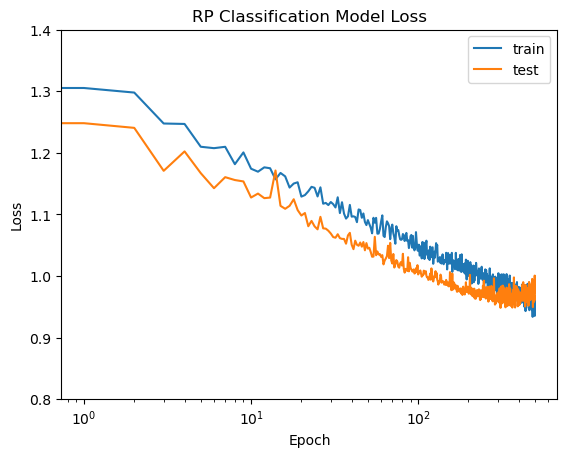

In [38]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
# plt.plot(train_losses_1, label = 'train Optuna 1')
# plt.plot(test_losses_1, label = 'test Optuna 1')
# plt.plot(train_losses_2, label = 'train Optuna 2')
# plt.plot(test_losses_2, label = 'test Optuna 2')
# plt.plot(train_losses_3, label = 'train Optuna 3')
# plt.plot(test_losses_3, label = 'test Optuna 3')
# plt.plot(train_losses_non, label = 'train no Optuna')
# plt.plot(test_losses_non, label = 'test no Optuna')
plt.xscale('log')
plt.ylim(0.8,1.4)
plt.legend()
plt.title("RP Classification Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Optuna

In [21]:
def dynamic_model(trial, input_size, output_size, max_layers=3, max_neurons_layers=500):
    # define the tuple containing the different layers
    layers = []
    # get the number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, max_layers)
    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, max_neurons_layers)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.8)
        layers.append(nn.Dropout(p))
        in_features = out_features
    # get the last layer
    layers.append(nn.Linear(out_features, output_size))
    # return the model
    return nn.Sequential(*layers)

In [22]:
import numpy as np
import sys, os, time
import torch
import torch.nn as nn
import optuna
import h5py

In [23]:
class Objective(object):
    def __init__(self, input_size, output_size, max_layers, max_neurons_layers, device,
                 epochs, seed, batch_size):

        self.input_size         = input_size
        self.output_size        = output_size
        self.max_layers         = max_layers
        self.max_neurons_layers = max_neurons_layers
        self.device             = device
        self.epochs             = epochs
        self.seed               = seed
        self.batch_size         = batch_size

    def __call__(self, trial):

        # name of the files that will contain the losses and model weights
        f1 = 'losses_%s'%prefix
        f2 = 'models_%s'%prefix
        if not(os.path.exists(f1)):  os.system('mkdir %s'%f1)
        if not(os.path.exists(f2)):  os.system('mkdir %s'%f2)

        fout   = 'losses_%s/loss_%d.txt'%(prefix, trial.number)
        fmodel = 'models_%s/model_%d.pt'%(prefix, trial.number)
        
        dataname = 'fesc_test' # name of your dataset, for the loss file header
        
        # write properties & headers in case you need to refer in the future and you've changed the main.py file
        f = open(fout, 'w')
        f.write('training dataset: {}\n'.format(dataname))
        f.write('seed = {}\numFeatures = {}\nFeature List: {}\nfluxSize = {}\nbatch_size = {}\nepochs     = {}\n'.format(seed, input_size, features, output_size, batch_size, epochs))
        f.write('0 epoch  1 train loss  2 test loss\n')
        f.close()

        # generate the architecture
        model = dynamic_model(trial, self.input_size, self.output_size, 
                            self.max_layers, self.max_neurons_layers).to(self.device)

        # get the weight decay and learning rate values
        ## adjust boundary values as needed
        lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
        wd = trial.suggest_float("wd", 1e-8, 1e-2,  log=True)

        # define the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.5, 0.999), 
                                      weight_decay=wd)

        # define loss function
        criterion = nn.CrossEntropyLoss() 

        # get the data
        train_loader = create_dataset('train', self.seed, fin, self.batch_size, True)
        valid_loader = create_dataset('valid', self.seed, fin, self.batch_size, False)
        test_loader  = create_dataset('test',  self.seed, fin, self.batch_size, False)

        # train/validate model
        min_valid = 1e40
        for epoch in range(self.epochs):

            # training
            train_loss, points = 0.0, 0
            model.train()
            for x, y in train_loader:
                x, y = x.to(self.device), y.to(self.device)
                y_NN = model(x)
                
                loss = criterion(y_NN, y)
                train_loss += (loss.item())*x.shape[0]
                points     += x.shape[0]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss /= points
            '''
            # validation
            valid_loss, points = 0.0, 0
            model.eval()
            with torch.no_grad():
                for x, y in valid_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    y_NN = model(x)
                    valid_loss += (criterion(y_NN, y).item())*x.shape[0]
                    points     += x.shape[0]
            valid_loss /= points
            '''
            # do testing
            test_loss, points = 0.0, 0
            model.eval()
            for x, y in test_loader:
                with torch.no_grad():
                    x    = x.to(device)
                    y    = y.to(device)
                    y_NN = model(x)
                    test_loss += (criterion(y_NN, y).item())*x.shape[0]
                    points    += x.shape[0]
            test_loss /= points
            
            #save this model if it's better
            if test_loss<min_valid:  
                min_valid = test_loss
                torch.save(model.state_dict(), fmodel)
            f = open(fout, 'a')
            f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
            f.close()

            # Handle pruning based on the intermediate value
            # comment out these lines if using pruning
            #trial.report(min_valid, epoch)
            #if trial.should_prune():  raise optuna.exceptions.TrialPruned()

        return min_valid


In [27]:
##################################### INPUT ##########################################
# data parameters
fin      = 'catalog.h5' # file containing your global properties
features = 'SFRs, Mstars, masses, redshifts, fgases, min_dist, t_lookback' # writing the order of input data as per data.py. Modify as needed
f_features_norm = None
f_labels  = 'fesc_new_var.txt' # file containing output SEDs
seed      = 5

# optuna architecture parameters
input_size         = 7 # number of input global properties
output_size        = 4 # size of SED/wavelength array
max_layers         = 5 # max number of hidden layers to test out
max_neurons_layers = 500 # max number of nodes per hidden layer to test out

# training parameters
batch_size = 256
epochs     = 1000

# optuna parameters -- modify as needed
prefix    = 'inp{}out{}maxl{}maxn{}bs{}ep{}'.format(input_size, output_size, max_layers, max_neurons_layers, batch_size, epochs)
study_name       = 'fesc_new_var' 
n_trials         = 50 # set to None for infinite
storage          = 'sqlite:///fesc_%s.db'%prefix 
n_jobs           = 1
n_startup_trials = 30 # random sample the hyperparameter space before running the model sampler
#########################


In [28]:
device = torch.device('cpu')

# define the optuna study and optimize it
objective = Objective(input_size, output_size, max_layers, max_neurons_layers, 
                      device, epochs, seed, batch_size)
sampler = optuna.samplers.TPESampler(n_startup_trials=n_startup_trials)
study = optuna.create_study(study_name=study_name, sampler=sampler, storage=storage,
                            load_if_exists=True)
study.optimize(objective, n_trials, n_jobs=n_jobs)


[I 2023-06-20 15:02:06,689] A new study created in RDB with name: fesc_new_var


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:04:50,363] Trial 0 finished with value: 0.982331120967865 and parameters: {'dropout_l0': 0.33393958385503586, 'dropout_l1': 0.7006599216561578, 'dropout_l2': 0.4321125919791734, 'dropout_l3': 0.24365747385740963, 'dropout_l4': 0.35508117685021956, 'lr': 0.00021678299223133925, 'n_layers': 5, 'n_units_l0': 471, 'n_units_l1': 131, 'n_units_l2': 167, 'n_units_l3': 103, 'n_units_l4': 481, 'wd': 3.80165269684692e-07}. Best is trial 0 with value: 0.982331120967865.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:08:30,747] Trial 1 finished with value: 0.9960491895675659 and parameters: {'dropout_l0': 0.48636256002377215, 'dropout_l1': 0.33041359492013184, 'dropout_l2': 0.5279354425362022, 'dropout_l3': 0.4084916834865569, 'lr': 0.0005385389169647407, 'n_layers': 4, 'n_units_l0': 217, 'n_units_l1': 187, 'n_units_l2': 10, 'n_units_l3': 359, 'wd': 0.00021246275032579402}. Best is trial 0 with value: 0.982331120967865.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:13:01,976] Trial 2 finished with value: 0.9434359431266784 and parameters: {'dropout_l0': 0.7624914685619695, 'dropout_l1': 0.2721929081245317, 'lr': 0.0026740312167035027, 'n_layers': 2, 'n_units_l0': 489, 'n_units_l1': 167, 'wd': 0.0075109779978422995}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:14:46,029] Trial 3 finished with value: 0.962491250038147 and parameters: {'dropout_l0': 0.735171339817063, 'dropout_l1': 0.2402103245546133, 'lr': 0.005027014314176093, 'n_layers': 2, 'n_units_l0': 147, 'n_units_l1': 450, 'wd': 2.597180305482603e-07}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:16:00,494] Trial 4 finished with value: 0.981823456287384 and parameters: {'dropout_l0': 0.36182858864628353, 'lr': 0.000897509550802675, 'n_layers': 1, 'n_units_l0': 453, 'wd': 7.640176857970094e-08}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:18:52,681] Trial 5 finished with value: 1.070496964454651 and parameters: {'dropout_l0': 0.61993963310815, 'dropout_l1': 0.41667611996209575, 'dropout_l2': 0.2964985483674233, 'lr': 3.386773486157398e-05, 'n_layers': 3, 'n_units_l0': 386, 'n_units_l1': 344, 'n_units_l2': 225, 'wd': 2.2219086630264198e-07}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:20:31,551] Trial 6 finished with value: 0.9513694763183593 and parameters: {'dropout_l0': 0.776733529099972, 'dropout_l1': 0.30854992702546846, 'lr': 0.001605484742759905, 'n_layers': 2, 'n_units_l0': 225, 'n_units_l1': 284, 'wd': 8.824675724827335e-05}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:23:11,017] Trial 7 finished with value: 0.9631398320198059 and parameters: {'dropout_l0': 0.5182298173644981, 'dropout_l1': 0.5407910037261705, 'dropout_l2': 0.5426031429876489, 'lr': 0.0012583437515201392, 'n_layers': 3, 'n_units_l0': 435, 'n_units_l1': 466, 'n_units_l2': 4, 'wd': 1.4873888814782947e-08}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:24:45,282] Trial 8 finished with value: 0.9517491936683655 and parameters: {'dropout_l0': 0.24492759123171137, 'dropout_l1': 0.6437301891866443, 'lr': 0.0006859317768542608, 'n_layers': 2, 'n_units_l0': 475, 'n_units_l1': 108, 'wd': 8.599508266897017e-08}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:25:53,269] Trial 9 finished with value: 1.0393765807151794 and parameters: {'dropout_l0': 0.5441562380568605, 'lr': 0.0001672282761814867, 'n_layers': 1, 'n_units_l0': 98, 'wd': 0.00037283368181678834}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:27:16,958] Trial 10 finished with value: 0.9616945385932922 and parameters: {'dropout_l0': 0.5807742937760634, 'dropout_l1': 0.3943929595194289, 'lr': 0.006948357371642309, 'n_layers': 2, 'n_units_l0': 181, 'n_units_l1': 138, 'wd': 0.00037438275225096864}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:31:35,351] Trial 11 finished with value: 1.0359375596046447 and parameters: {'dropout_l0': 0.7000528736079263, 'dropout_l1': 0.5198012282358841, 'dropout_l2': 0.6113876723200045, 'dropout_l3': 0.3257635661960461, 'dropout_l4': 0.20959859000832806, 'lr': 0.00983003838681644, 'n_layers': 5, 'n_units_l0': 80, 'n_units_l1': 482, 'n_units_l2': 203, 'n_units_l3': 425, 'n_units_l4': 357, 'wd': 0.0005087124042516762}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:33:08,973] Trial 12 finished with value: 1.0021517038345338 and parameters: {'dropout_l0': 0.5561126388009359, 'dropout_l1': 0.2459048642541918, 'lr': 0.00020106897290276247, 'n_layers': 2, 'n_units_l0': 273, 'n_units_l1': 108, 'wd': 0.001394916694000129}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:34:15,377] Trial 13 finished with value: 0.9954982161521911 and parameters: {'dropout_l0': 0.5586264633283231, 'lr': 0.007328569454541996, 'n_layers': 1, 'n_units_l0': 289, 'wd': 0.0008822147971861557}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:35:33,114] Trial 14 finished with value: 1.1005836963653564 and parameters: {'dropout_l0': 0.29617270376008276, 'lr': 1.430538377881181e-05, 'n_layers': 1, 'n_units_l0': 270, 'wd': 1.7484369399676876e-06}. Best is trial 2 with value: 0.9434359431266784.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:36:52,594] Trial 15 finished with value: 0.9129868745803833 and parameters: {'dropout_l0': 0.5221870298887965, 'dropout_l1': 0.2067096671755474, 'lr': 0.0032696939905353085, 'n_layers': 2, 'n_units_l0': 353, 'n_units_l1': 468, 'wd': 1.977097970635191e-05}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:38:27,573] Trial 16 finished with value: 0.920417046546936 and parameters: {'dropout_l0': 0.49536696127472796, 'dropout_l1': 0.503435002569846, 'dropout_l2': 0.6972310091105698, 'dropout_l3': 0.35354974999703404, 'lr': 0.0008336971475209042, 'n_layers': 4, 'n_units_l0': 300, 'n_units_l1': 233, 'n_units_l2': 358, 'n_units_l3': 221, 'wd': 8.320090511597038e-07}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:39:48,523] Trial 17 finished with value: 0.9713522434234619 and parameters: {'dropout_l0': 0.43127242790495185, 'dropout_l1': 0.45613982338993797, 'dropout_l2': 0.5247135581890767, 'lr': 0.002804942561231948, 'n_layers': 3, 'n_units_l0': 18, 'n_units_l1': 339, 'n_units_l2': 494, 'wd': 3.246530842279709e-08}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:40:26,339] Trial 18 finished with value: 1.039818775653839 and parameters: {'dropout_l0': 0.43919625805284257, 'lr': 0.0002938679610608228, 'n_layers': 1, 'n_units_l0': 47, 'wd': 1.93245950336504e-05}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:41:56,354] Trial 19 finished with value: 0.9583373546600342 and parameters: {'dropout_l0': 0.30807261095024857, 'dropout_l1': 0.7067690913633773, 'dropout_l2': 0.2389817845026338, 'dropout_l3': 0.3322085487033089, 'lr': 0.004427289951609615, 'n_layers': 4, 'n_units_l0': 308, 'n_units_l1': 53, 'n_units_l2': 380, 'n_units_l3': 487, 'wd': 0.0018739984601215435}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:42:38,490] Trial 20 finished with value: 0.9490190505981445 and parameters: {'dropout_l0': 0.24300580770617686, 'lr': 0.0026074006759025086, 'n_layers': 1, 'n_units_l0': 476, 'wd': 6.858098966131163e-05}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:44:36,077] Trial 21 finished with value: 0.9967051982879639 and parameters: {'dropout_l0': 0.29725417295109485, 'dropout_l1': 0.3817743065944507, 'dropout_l2': 0.5633093037068924, 'dropout_l3': 0.3517341772061702, 'lr': 5.918121556943106e-05, 'n_layers': 4, 'n_units_l0': 444, 'n_units_l1': 492, 'n_units_l2': 157, 'n_units_l3': 437, 'wd': 5.619828412160003e-05}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:45:46,924] Trial 22 finished with value: 1.1137755393981934 and parameters: {'dropout_l0': 0.42234574585239026, 'dropout_l1': 0.4133752561438446, 'dropout_l2': 0.31457915622817645, 'lr': 1.674489326155659e-05, 'n_layers': 3, 'n_units_l0': 93, 'n_units_l1': 269, 'n_units_l2': 387, 'wd': 9.572526867433748e-07}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:47:16,607] Trial 23 finished with value: 0.9578617453575134 and parameters: {'dropout_l0': 0.2984940297484327, 'dropout_l1': 0.39087145420749303, 'dropout_l2': 0.6690022308976263, 'dropout_l3': 0.6900128695934682, 'dropout_l4': 0.33303470849461714, 'lr': 0.001208301726677123, 'n_layers': 5, 'n_units_l0': 16, 'n_units_l1': 268, 'n_units_l2': 287, 'n_units_l3': 121, 'n_units_l4': 231, 'wd': 1.7550431128686335e-07}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:48:17,227] Trial 24 finished with value: 1.0779441118240356 and parameters: {'dropout_l0': 0.27844743757288304, 'dropout_l1': 0.622484332570461, 'dropout_l2': 0.5861651268154926, 'dropout_l3': 0.2705341791863167, 'lr': 2.8495176780880696e-05, 'n_layers': 4, 'n_units_l0': 368, 'n_units_l1': 97, 'n_units_l2': 36, 'n_units_l3': 240, 'wd': 7.398229949252343e-05}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:49:12,289] Trial 25 finished with value: 0.9526599407196045 and parameters: {'dropout_l0': 0.5651224802440253, 'dropout_l1': 0.338494682497239, 'lr': 0.0005303555790422947, 'n_layers': 2, 'n_units_l0': 274, 'n_units_l1': 257, 'wd': 0.002817583391395743}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:49:56,808] Trial 26 finished with value: 1.0905129313468933 and parameters: {'dropout_l0': 0.37052560096665876, 'lr': 1.55716603042178e-05, 'n_layers': 1, 'n_units_l0': 321, 'wd': 0.00835772545860903}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:51:06,806] Trial 27 finished with value: 0.9476043224334717 and parameters: {'dropout_l0': 0.5196198845748177, 'dropout_l1': 0.5758360505564595, 'dropout_l2': 0.780452501142747, 'dropout_l3': 0.5546022388880387, 'lr': 0.0018733245431178582, 'n_layers': 4, 'n_units_l0': 228, 'n_units_l1': 114, 'n_units_l2': 193, 'n_units_l3': 369, 'wd': 2.148810757498486e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:52:13,801] Trial 28 finished with value: 0.9577541708946228 and parameters: {'dropout_l0': 0.6022643432303676, 'dropout_l1': 0.7907305605149546, 'lr': 0.0009785340514887214, 'n_layers': 2, 'n_units_l0': 309, 'n_units_l1': 402, 'wd': 1.3410816329062914e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:53:40,185] Trial 29 finished with value: 1.339839553833008 and parameters: {'dropout_l0': 0.634857113439183, 'dropout_l1': 0.7094987290932124, 'dropout_l2': 0.6062120500028221, 'dropout_l3': 0.5942554594236489, 'dropout_l4': 0.22788213297211554, 'lr': 1.0048632355054055e-05, 'n_layers': 5, 'n_units_l0': 80, 'n_units_l1': 116, 'n_units_l2': 440, 'n_units_l3': 198, 'n_units_l4': 346, 'wd': 1.2416360465414836e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:54:53,725] Trial 30 finished with value: 0.9315887093544006 and parameters: {'dropout_l0': 0.6603864235476942, 'dropout_l1': 0.20928942408050982, 'dropout_l2': 0.7682376186523345, 'lr': 0.002740758388701768, 'n_layers': 3, 'n_units_l0': 395, 'n_units_l1': 213, 'n_units_l2': 308, 'wd': 7.4391897450519056e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:56:03,540] Trial 31 finished with value: 0.9437678217887878 and parameters: {'dropout_l0': 0.7183420352582627, 'dropout_l1': 0.20970255239372446, 'dropout_l2': 0.798081600057772, 'lr': 0.0024574352619560064, 'n_layers': 3, 'n_units_l0': 391, 'n_units_l1': 202, 'n_units_l2': 310, 'wd': 1.0124676591150336e-05}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:57:52,748] Trial 32 finished with value: 0.937476372718811 and parameters: {'dropout_l0': 0.6565962156393423, 'dropout_l1': 0.2022341961693039, 'dropout_l2': 0.7089706194849604, 'lr': 0.003420225728340451, 'n_layers': 3, 'n_units_l0': 351, 'n_units_l1': 189, 'n_units_l2': 348, 'wd': 4.213779862471031e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 15:59:41,531] Trial 33 finished with value: 0.9586429834365845 and parameters: {'dropout_l0': 0.6655895115909705, 'dropout_l1': 0.2180014652743642, 'dropout_l2': 0.7126050782519465, 'lr': 0.004078052629650889, 'n_layers': 3, 'n_units_l0': 355, 'n_units_l1': 218, 'n_units_l2': 331, 'wd': 5.815900924107601e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:03:35,251] Trial 34 finished with value: 0.9540325284004212 and parameters: {'dropout_l0': 0.6713431198556327, 'dropout_l1': 0.27881744963656807, 'dropout_l2': 0.7087172019832841, 'lr': 0.003473628200997773, 'n_layers': 3, 'n_units_l0': 340, 'n_units_l1': 313, 'n_units_l2': 375, 'wd': 4.661103167696507e-06}. Best is trial 15 with value: 0.9129868745803833.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:05:07,744] Trial 35 finished with value: 0.8917077541351318 and parameters: {'dropout_l0': 0.48863978086778387, 'dropout_l1': 0.21644333572567157, 'dropout_l2': 0.740357547306882, 'dropout_l3': 0.459542635372583, 'lr': 0.001774009534655271, 'n_layers': 4, 'n_units_l0': 408, 'n_units_l1': 225, 'n_units_l2': 342, 'n_units_l3': 14, 'wd': 4.768950177436398e-07}. Best is trial 35 with value: 0.8917077541351318.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:06:28,832] Trial 36 finished with value: 0.8930970430374146 and parameters: {'dropout_l0': 0.48440779518112037, 'dropout_l1': 0.2961695821651202, 'dropout_l2': 0.7677010963862043, 'dropout_l3': 0.4549038707548857, 'lr': 0.001660310826926707, 'n_layers': 4, 'n_units_l0': 408, 'n_units_l1': 224, 'n_units_l2': 272, 'n_units_l3': 76, 'wd': 3.361976536569725e-07}. Best is trial 35 with value: 0.8917077541351318.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:08:00,417] Trial 37 finished with value: 0.879586398601532 and parameters: {'dropout_l0': 0.47455646387688233, 'dropout_l1': 0.2751854259494696, 'dropout_l2': 0.6564052005260577, 'dropout_l3': 0.44116917438303693, 'lr': 0.001872910879768054, 'n_layers': 4, 'n_units_l0': 421, 'n_units_l1': 241, 'n_units_l2': 259, 'n_units_l3': 10, 'wd': 4.238852508107672e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:09:48,953] Trial 38 finished with value: 0.8837631344795227 and parameters: {'dropout_l0': 0.4689194333804595, 'dropout_l1': 0.27853348567511466, 'dropout_l2': 0.6579783918681, 'dropout_l3': 0.4649898379840014, 'lr': 0.001515786595230431, 'n_layers': 4, 'n_units_l0': 419, 'n_units_l1': 401, 'n_units_l2': 259, 'n_units_l3': 17, 'wd': 5.073674397383767e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:11:45,080] Trial 39 finished with value: 0.8828600525856019 and parameters: {'dropout_l0': 0.47371873904011047, 'dropout_l1': 0.29713489602988824, 'dropout_l2': 0.6701304101882272, 'dropout_l3': 0.46994793161825293, 'lr': 0.0017749751008626794, 'n_layers': 4, 'n_units_l0': 413, 'n_units_l1': 311, 'n_units_l2': 242, 'n_units_l3': 7, 'wd': 3.4166297761904853e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:13:43,389] Trial 40 finished with value: 0.9280438899993897 and parameters: {'dropout_l0': 0.4556670523860331, 'dropout_l1': 0.3401696923858758, 'dropout_l2': 0.6582508580230976, 'dropout_l3': 0.47174888792087005, 'dropout_l4': 0.7969951155680518, 'lr': 0.00168117404694576, 'n_layers': 5, 'n_units_l0': 498, 'n_units_l1': 388, 'n_units_l2': 248, 'n_units_l3': 24, 'n_units_l4': 14, 'wd': 6.157210890453529e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:15:10,401] Trial 41 finished with value: 0.8917815804481506 and parameters: {'dropout_l0': 0.47233569786869883, 'dropout_l1': 0.2857463429845629, 'dropout_l2': 0.7410662372153021, 'dropout_l3': 0.4645027486619855, 'lr': 0.0015329795615217831, 'n_layers': 4, 'n_units_l0': 418, 'n_units_l1': 307, 'n_units_l2': 269, 'n_units_l3': 18, 'wd': 3.595692477557405e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:16:31,729] Trial 42 finished with value: 0.9028298377990722 and parameters: {'dropout_l0': 0.47014416458524605, 'dropout_l1': 0.2608105912535361, 'dropout_l2': 0.6345112672612111, 'dropout_l3': 0.47903706672833396, 'lr': 0.0013609132568937813, 'n_layers': 4, 'n_units_l0': 423, 'n_units_l1': 301, 'n_units_l2': 250, 'n_units_l3': 5, 'wd': 4.786249548296068e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:18:26,262] Trial 43 finished with value: 0.8818724870681762 and parameters: {'dropout_l0': 0.40839958526770187, 'dropout_l1': 0.269330933891966, 'dropout_l2': 0.7437001032155125, 'dropout_l3': 0.431128971050538, 'lr': 0.0020712469629839427, 'n_layers': 4, 'n_units_l0': 455, 'n_units_l1': 388, 'n_units_l2': 270, 'n_units_l3': 47, 'wd': 1.7154192813923185e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:20:59,184] Trial 44 finished with value: 0.8958772182464599 and parameters: {'dropout_l0': 0.402963857517574, 'dropout_l1': 0.251857942468737, 'dropout_l2': 0.6786291777739334, 'dropout_l3': 0.3980190883611726, 'lr': 0.0019378212890088728, 'n_layers': 4, 'n_units_l0': 458, 'n_units_l1': 392, 'n_units_l2': 122, 'n_units_l3': 64, 'wd': 1.4070465805570773e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:24:28,274] Trial 45 finished with value: 0.9162165880203247 and parameters: {'dropout_l0': 0.3996868866990714, 'dropout_l1': 0.3241011032731031, 'dropout_l2': 0.6475490675661548, 'dropout_l3': 0.5259798652900329, 'dropout_l4': 0.6025474644127973, 'lr': 0.0006131448388553191, 'n_layers': 5, 'n_units_l0': 449, 'n_units_l1': 429, 'n_units_l2': 238, 'n_units_l3': 53, 'n_units_l4': 16, 'wd': 7.896115141181758e-08}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:26:14,526] Trial 46 finished with value: 0.9105929017066956 and parameters: {'dropout_l0': 0.5046517926534961, 'dropout_l1': 0.24710133550341526, 'dropout_l2': 0.7308310810601065, 'dropout_l3': 0.43409314432854307, 'lr': 0.0010976790571958816, 'n_layers': 4, 'n_units_l0': 382, 'n_units_l1': 340, 'n_units_l2': 295, 'n_units_l3': 134, 'wd': 2.271497397155509e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:27:33,471] Trial 47 finished with value: 0.9679741382598877 and parameters: {'dropout_l0': 0.4467808325269676, 'dropout_l1': 0.3032881607601192, 'dropout_l2': 0.750212175251294, 'dropout_l3': 0.5058818422782997, 'dropout_l4': 0.5473206464163488, 'lr': 0.004943387155243046, 'n_layers': 5, 'n_units_l0': 474, 'n_units_l1': 170, 'n_units_l2': 165, 'n_units_l3': 10, 'n_units_l4': 162, 'wd': 4.290777816423658e-08}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:29:20,834] Trial 48 finished with value: 0.890935230255127 and parameters: {'dropout_l0': 0.5303725287410224, 'dropout_l1': 0.2636913391960406, 'dropout_l2': 0.6349190010240999, 'dropout_l3': 0.41741713679353165, 'lr': 0.002177276700733376, 'n_layers': 4, 'n_units_l0': 431, 'n_units_l1': 368, 'n_units_l2': 328, 'n_units_l3': 59, 'wd': 1.2295245982575016e-07}. Best is trial 37 with value: 0.879586398601532.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 7]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 7]) torch.Size([320])


[I 2023-06-20 16:30:58,889] Trial 49 finished with value: 0.9140231370925903 and parameters: {'dropout_l0': 0.5250663721820188, 'dropout_l1': 0.27639981046101364, 'dropout_l2': 0.6313103938139905, 'dropout_l3': 0.40452710874527675, 'lr': 0.0008260002795176899, 'n_layers': 4, 'n_units_l0': 437, 'n_units_l1': 372, 'n_units_l2': 215, 'n_units_l3': 166, 'wd': 1.3963716318670618e-07}. Best is trial 37 with value: 0.879586398601532.


## Regression

In [67]:
all_halo_props_at_all_z = {}
for halo in ds.keys():
    halo_props_at_all_z = {}
    for idx, z in enumerate(list(ds[halo]['redshift'])):
        if list(ds[halo]['fesc'])[idx] >= 1e-5:
            halo_props_at_all_z[z] = [list(ds[halo]['SFR'])[idx], list(ds[halo]['Mstar'])[idx], list(ds[halo]['mass'])[idx], \
                                          list(ds[halo]['fgas'])[idx], list(ds[halo]['redshift'])[idx], list(ds[halo]['fesc'])[idx]]
    #if len(list(halo_props_at_all_z.keys())) == 0:
    #    continue
    all_halo_props_at_all_z[halo] = halo_props_at_all_z
print(all_halo_props_at_all_z)



{'Halo00000000': {15.0: [1.2836542968554272, 59134222.80734978, 1954713246.2693987, 0.1998359278941855, 15.0, 0.09360607274200473], 15.100466913540494: [1.3703240577169347, 58666978.02856003, 1849300554.7800016, 0.20124005174649698, 15.100466913540494, 0.09957865948250233], 15.199578810950914: [1.5116405794074366, 58769888.415024646, 1731249349.5830407, 0.20696624499888355, 15.199578810950914, 0.07355974194734793], 15.299918500407497: [1.7580104873177935, 57599444.38820782, 1616816462.5769281, 0.21241025953988596, 15.299918500407497, 0.07895663477923952], 15.39881928501148: [1.7693053460191923, 52498303.44679414, 1506271404.67002, 0.2191438315742533, 15.39881928501148, 0.08169713880394888], 15.49892756970797: [1.5511139077326486, 44133576.19873784, 1336177194.4688811, 0.21134163151891364, 15.49892756970797, 0.0870634954922673], 15.600265604249667: [1.5409682927758837, 41319855.409174025, 1268353046.624506, 0.20860688938157387, 15.600265604249667, 0.10411679730879066], 15.70006680026720

In [171]:
all_halo_props_at_all_z

{'Halo00000000': {15.0: [1.2836542968554272,
   59134222.80734978,
   1954713246.2693987,
   0.1998359278941855,
   15.0,
   0.09360607274200473],
  15.100466913540494: [1.3703240577169347,
   58666978.02856003,
   1849300554.7800016,
   0.20124005174649698,
   15.100466913540494,
   0.09957865948250233],
  15.199578810950914: [1.5116405794074366,
   58769888.415024646,
   1731249349.5830407,
   0.20696624499888355,
   15.199578810950914,
   0.07355974194734793],
  15.299918500407497: [1.7580104873177935,
   57599444.38820782,
   1616816462.5769281,
   0.21241025953988596,
   15.299918500407497,
   0.07895663477923952],
  15.39881928501148: [1.7693053460191923,
   52498303.44679414,
   1506271404.67002,
   0.2191438315742533,
   15.39881928501148,
   0.08169713880394888],
  15.49892756970797: [1.5511139077326486,
   44133576.19873784,
   1336177194.4688811,
   0.21134163151891364,
   15.49892756970797,
   0.0870634954922673],
  15.600265604249667: [1.5409682927758837,
   41319855.40917

In [68]:
redshifts40 = []
for halo in ds.keys():
    if len(list(ds[halo]['redshift'])) == 40:
           redshifts40 = list(ds[halo]['redshift'])
print(redshifts40)


[15.0, 15.100466913540494, 15.199578810950914, 15.299918500407497, 15.39881928501148, 15.49892756970797, 15.600265604249667, 15.700066800267201, 15.801075268817204, 15.900456312320433, 16.001020061203672, 16.099863201094394, 16.19986240110079, 16.301038062283737, 16.400382808421785, 16.50087504375219, 16.59943681802182, 16.699115044247787, 16.7999288002848, 16.898693395382136, 16.998560115190784, 17.099547511312217, 17.20167455405897, 17.301610541727673, 17.39926402943882, 17.501387604070306, 17.9000189000189, 18.00057001710051, 18.50078003120125, 19.0, 19.500205002050023, 19.999580008399832, 20.50075252633842, 20.997360316761988, 21.502250225022504, 21.999080036798528, 22.501762632197416, 22.998080153587715, 23.49779519843214, 24.0]


In [75]:
all_properties = []
for halo_idx, halo_num in enumerate(list(all_halo_props_at_all_z.keys())):
    halo_props = []
    temp = all_halo_props_at_all_z[halo_num].keys()
    try:
        min_props = all_halo_props_at_all_z[halo_num].get(max(temp))
    except:
        continue
    for redshift in redshifts40:
        if redshift not in temp:
            halo_props.append(min_props)
        else:
            halo_props.append(all_halo_props_at_all_z[halo_num].get(redshift))
    all_properties.append(halo_props)


In [76]:
all_properties_reshape = np.reshape(np.array(all_properties), (151,40,6))

In [80]:
# reshaped = np.empty((151,40,6))
# for idx, each in enumerate(all_properties):
#     print(np.array(each).shape)
#     #reshaped[idx] = np.array(each)
    
    
print(np.array(all_properties).shape)

(151, 40, 6)


In [81]:
np.save('all_properties_reshape.npy', all_properties_reshape)

In [86]:
X = all_properties_reshape
y = all_properties_reshape[:,:,5]

In [134]:
X_train = torch.Tensor(X[15:,:,0:5])
y_train = torch.Tensor(y[15:,:])
X_val = torch.Tensor(X[:15, :, 0:5])
y_val = torch.Tensor(y[:15, :])

In [135]:
print(X_train.shape, y_train.shape)

torch.Size([136, 40, 5]) torch.Size([136, 40])


In [136]:
import torch.nn as nn
seq_model = nn.Sequential(
    nn.Linear(5, 4),
    nn.Tanh(),
    nn.Linear(4, 1))

In [150]:
def training_loop(n_epochs, optimiser, model, loss_fn, X_train,  X_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        output_train = model(X_train)
        output_train = torch.reshape(output_train, (output_train.shape[0], output_train.shape[1]))# forwards pass
        loss_train = loss_fn(output_train, y_train) # calculate loss
        output_val = model(X_val) 
        output_val = torch.reshape(output_val, (output_val.shape[0], output_val.shape[1]))
        loss_val = loss_fn(output_val, y_val)

        optimiser.zero_grad() # set gradients to zero
        loss_train.backward() # backwards pass
        optimiser.step() # update model parameters
        if epoch == 1 or epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [152]:
import torch.optim as optim
optimiser = optim.Adam(seq_model.parameters(), lr=0.001872910879768054)

In [154]:
training_loop(
    n_epochs = 100000, 
    optimiser = optimiser,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    X_train = X_train,
    X_val = X_val, 
    y_train = y_train,
    y_val = y_val)

Epoch 1, Training loss 0.0440, Validation loss 0.0409
Epoch 100, Training loss 0.0440, Validation loss 0.0409
Epoch 200, Training loss 0.0440, Validation loss 0.0409
Epoch 300, Training loss 0.0440, Validation loss 0.0409
Epoch 400, Training loss 0.0440, Validation loss 0.0409
Epoch 500, Training loss 0.0440, Validation loss 0.0409
Epoch 600, Training loss 0.0440, Validation loss 0.0409
Epoch 700, Training loss 0.0440, Validation loss 0.0409
Epoch 800, Training loss 0.0440, Validation loss 0.0409
Epoch 900, Training loss 0.0440, Validation loss 0.0409
Epoch 1000, Training loss 0.0440, Validation loss 0.0409
Epoch 1100, Training loss 0.0440, Validation loss 0.0409
Epoch 1200, Training loss 0.0440, Validation loss 0.0409
Epoch 1300, Training loss 0.0440, Validation loss 0.0409
Epoch 1400, Training loss 0.0440, Validation loss 0.0409
Epoch 1500, Training loss 0.0440, Validation loss 0.0409
Epoch 1600, Training loss 0.0440, Validation loss 0.0409
Epoch 1700, Training loss 0.0440, Validatio

KeyboardInterrupt: 

## LSTM

In [155]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [170]:
rnn = torch.nn.LSTM(batch_first = True, input_size = 6, hidden_size = 3, bias = True)
input_ = torch.Tensor(all_properties_reshape)
print(f'input {input_}')
h0 = torch.randn(1, 151, 3)
c0 = torch.randn(1, 151, 3)
output, (hn, cn) = rnn(input_, (h0, c0))
print(f'output {output}')

input tensor([[[1.2837e+00, 5.9134e+07, 1.9547e+09, 1.9984e-01, 1.5000e+01,
          9.3606e-02],
         [1.3703e+00, 5.8667e+07, 1.8493e+09, 2.0124e-01, 1.5100e+01,
          9.9579e-02],
         [1.5116e+00, 5.8770e+07, 1.7312e+09, 2.0697e-01, 1.5200e+01,
          7.3560e-02],
         ...,
         [9.8493e-04, 1.9850e+04, 7.4153e+06, 1.2676e-01, 2.1999e+01,
          1.9997e-03],
         [9.8493e-04, 1.9850e+04, 7.4153e+06, 1.2676e-01, 2.1999e+01,
          1.9997e-03],
         [9.8493e-04, 1.9850e+04, 7.4153e+06, 1.2676e-01, 2.1999e+01,
          1.9997e-03]],

        [[1.2746e-01, 3.5151e+06, 1.6947e+09, 1.0717e-01, 1.5000e+01,
          7.2730e-02],
         [9.2515e-02, 2.4419e+06, 1.6854e+09, 1.0672e-01, 1.5100e+01,
          1.8867e-01],
         [7.9573e-02, 2.0239e+06, 1.5062e+09, 9.9770e-02, 1.5200e+01,
          1.7776e-01],
         ...,
         [7.7743e-04, 1.5567e+04, 4.4084e+07, 1.0022e-01, 1.8001e+01,
          8.8989e-04],
         [7.7743e-04, 1.5567e+04, 